# Surface Code
Notebook for playing around and building a surface code using Qiskit. We begin by following [An introduction to the surface code, Andrew N. Cleland](https://scipost.org/SciPostPhysLectNotes.49/pdf). 

### Simple Examples
Let's first create the quantum circuit for one surface code cycle for a measure-Z qubit, forcing data qubits into an eigenstate of (stabilizes) $Z_0Z_1Z_2Z_3$ and for a measure-X qubit, which stabilizes $X_0X_1X_2X_3$ (i.e. figure 20 from the paper).

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.quantum_info import Statevector
import numpy as np

#Declare backend we will use throughout
simulator = Aer.get_backend('aer_simulator')

# Create a Quantum Register with 5 qubits (4 data qubits and 1 ancilla qubit for stabilzer +measurement)
qreg = QuantumRegister(5, 'q')

# Create a Classical Register with 1 bit
creg = ClassicalRegister(1, 'c')

# Create an Z measure Quantum Circuit 
Zcircuit = QuantumCircuit(qreg, creg)

# Entangle the data qubits with the ancilla qubit
for i in range(1,5):
    Zcircuit.cx(qreg[i], qreg[0])  # Apply CX gate between data qubit and ancilla

# Measure the ancilla qubit and store the result in the classical bit
Zcircuit.measure(qreg[0], creg[0])

Zcircuit.draw()

┌───┐┌───┐┌───┐┌───┐┌─┐
q_0: ┤ X ├┤ X ├┤ X ├┤ X ├┤M├
     └─┬─┘└─┬─┘└─┬─┘└─┬─┘└╥┘
q_1: ──■────┼────┼────┼───╫─
            │    │    │   ║ 
q_2: ───────■────┼────┼───╫─
                 │    │   ║ 
q_3: ────────────■────┼───╫─
                      │   ║ 
q_4: ─────────────────■───╫─
                          ║ 
c: 1/═════════════════════╩═
                          0

Once we make projective measurement of the measure qubits e.g. for $Z$ measure qubit, the state will
be $$Z_{0123}|\psi\rangle$$ ($Z_{0123} = \pm 1$). This state is the quiescent state. When we extend to a full array, starting with the very first complete measurement cycle when starting up a surface code, the $Z$ measure and $X$ measure take whatever initial state the data qubits are in, and project from that state a complex entangled state $|\psi\rangle$ that is a simultaneous eigenstate of all the measurements across the array. Once selected, in the absence of errors, the same state $|\psi\rangle$ will be maintained by each
subsequent cycle of the sequence, with each measure qubit yielding the same measurement
outcome as it measured in the previous cycle (due to the stabilizer measurements commuting). Let's illustrate this by first just considering the $Z$ measure circuit.

In [2]:
num_cycles = 5

# Create a Quantum Register with 5 qubits (4 data qubits and 1 ancilla qubit for stabilizer + measurement)
qreg = QuantumRegister(5, 'q')
# Create a Classical Register with a bit for each cycle
creg = ClassicalRegister(num_cycles, 'c')
# Create a Quantum Circuit for each cycle
Zcircuit = QuantumCircuit(qreg, creg)

# Create an arbitrary initial state for data qubits (we choose 1/sqrt{2}(|0000> + |0111>) for illustration)
Zcircuit.h(1)
Zcircuit.cx(1,2)
Zcircuit.cx(2,3)

for cycle in range(num_cycles):
    # Reset the ancilla qubit to the |0> state
    Zcircuit.reset(qreg[0])

    # Entangle the data qubits with the ancilla qubit
    for i in range(1, 5):
        Zcircuit.cx(qreg[i], qreg[0])

    # Seeing the state of our initial circuit for visualization
    if cycle == 0:
        state_simulator = Aer.get_backend('statevector_simulator')
        job = execute(Zcircuit, state_simulator)
        state_vector = job.result().get_statevector()

    # Measure the ancilla qubit and store the result in the classical register
    Zcircuit.measure(qreg[0], creg[cycle])

# Execute the circuit
job = execute(Zcircuit, simulator, shots=1)
result = job.result().get_counts()

# Print pre-measurement state
print("Pre Measurement State: ", np.asarray(state_vector).real, "\n")

# Extract and print the measurement result for each cycle
measurement_results = list(result.keys())[0]  # Assuming a single shot, so only one key
for cycle in range(num_cycles):
    # In Qiskit, the bits are in reverse order
    cycle_measurement = measurement_results[-1-cycle]
    print(f"Cycle {cycle} Measurement: {cycle_measurement}")


Pre Measurement State:  [0.70710678 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.70710678 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] 

Cycle 0 Measurement: 1
Cycle 1 Measurement: 1
Cycle 2 Measurement: 1
Cycle 3 Measurement: 1
Cycle 4 Measurement: 1


Here we can see an illustration of this. The initial state is $$\frac{1}{\sqrt{2}} (|0000\rangle + |0111\rangle)\otimes |0\rangle$$. Then, after the cycle (pre-measurement), the ancilla becomes entangled with the data qubits and the state is $1/\sqrt{2} (|00000\rangle + |01111\rangle)$. Now we can clearly see that a measurement of 0 or 1 of the ancilla will causes the state to collapse to a +1 ($|0000\rangle$) or -1 ($|0111\rangle$)  eigenstate of the $Z_0 Z_1 Z_2 Z_3$ stabilizer respectively. This collpased state is the quiescent state, and we can see from the other ancilla qubit measurements that this state remains throughout the following cycles (provided there's no errors!). We can now see this is the case for the $X$-measure qubit too.

In [3]:
num_cycles = 3

# Create a Quantum Register with 5 qubits (4 data qubits and 1 ancilla qubit for stabilizer + measurement)
qreg = QuantumRegister(5, 'q')
# Create a Classical Register with a bit for each cycle
creg = ClassicalRegister(num_cycles, 'c')
# Create a Quantum Circuit for each cycle
Xcircuit = QuantumCircuit(qreg, creg)

# Initialize data qubits to |0000>
# No additional gates needed as qubits are initialized to |0> by default

for cycle in range(num_cycles):
    # Reset the ancilla qubit to the |0> state
    Xcircuit.reset(qreg[0])

    #Change ancilla basis
    Xcircuit.h(qreg[0])

    # Entangle the data qubits with the ancilla qubit (now ancilla is the control)
    for i in range(1, 5):
        Xcircuit.cx(qreg[0], qreg[i])


    #Change the ancilla basis
    Xcircuit.h(qreg[0])
    
    # Seeing the state of our initial circuit for visualization
    if cycle == 0:
        state_simulator = Aer.get_backend('statevector_simulator')
        job = execute(Xcircuit, state_simulator)
        state_vector = job.result().get_statevector()

    # Measure the ancilla qubit and store the result in the classical register
    Xcircuit.measure(qreg[0], creg[cycle])

# Execute the circuit
simulator = Aer.get_backend('aer_simulator')
job = execute(Xcircuit, simulator, shots=1)
result = job.result().get_counts()

# Print pre-measurement state
print("Pre Measurement State: ", np.asarray(state_vector).real, "\n")

# Extract and print the measurement result for each cycle
measurement_results = list(result.keys())[0]  # Assuming a single shot, so only one key
for cycle in range(num_cycles):
    # In Qiskit, the bits are in reverse order
    cycle_measurement = measurement_results[-1-cycle]
    print(f"Cycle {cycle} Measurement: {cycle_measurement}")


Pre Measurement State:  [ 0.5  0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.5 -0.5] 

Cycle 0 Measurement: 0
Cycle 1 Measurement: 0
Cycle 2 Measurement: 0


We also see the same thing here. The initial state of the data qubits is $|0000\rangle$, then the entanglement with the ancilla projects the state to 
$$
\large |\psi\rangle = \frac{1}{2}\left((|0000\rangle + |1111\rangle) \otimes |0\rangle + (|0000\rangle - |1111\rangle) \otimes |1\rangle)\right).
$$
So then measurement of the $X$-type ancilla leaves the system in one of two possible eigenstates of $X_1X_2X_3X_4$, with the ancilla measurement indicating which: 0 (1) for +1 (-1) eigenvalue.

### 7 qubit Error Detection Surface Code
The smallest possible surface code (working from [Repeated Quantum Error Detection in a Surface Code](https://arxiv.org/pdf/1912.09410.pdf)) has 7 qubits, 4 data qubits ($D_1, D_2, D_3, D_4$), 2 $Z$ ancillas ($Z_1Z_2$) and 1 $X$ ancilla ($X_1$).

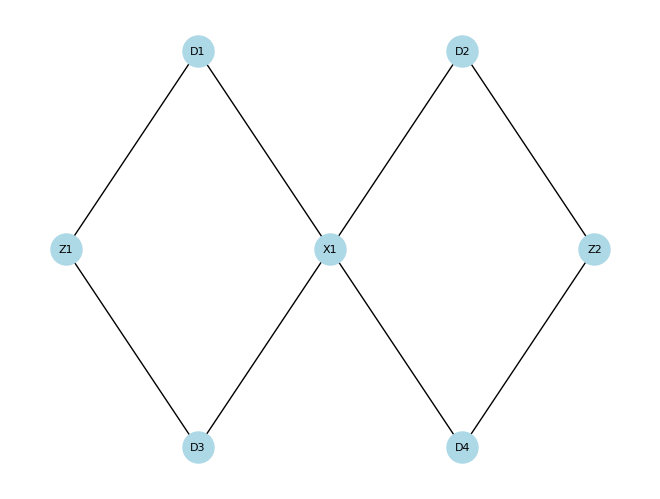

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a new graph
G = nx.Graph()

# Add nodes with positions
positions = {'D1': (0, 1), 'D2': (2, 1), 'D3': (0, -1), 'D4': (2, -1),
             'Z1': (-1, 0), 'X1': (1, 0), 'Z2': (3,0 )}

for node, pos in positions.items():
    G.add_node(node, pos=pos)

# Add edges between nodes
edges = [('D1', 'Z1'), ('D1', 'X1'), ('D2', 'X1'), ('D2', 'Z2'), 
         ('D3', 'Z1'), ('D3', 'X1'), ('D4', 'X1'), ('D4', 'Z2')]

G.add_edges_from(edges)

# Draw the graph
nx.draw(G, positions, with_labels=True, node_size=500, node_color='lightblue', font_size=8)
plt.show()


Let's try to build the circuit, using what we know from above and the Cleland paper. Qubit 4 will be the X ancilla, qubits 5 (z1) and 6 (z2) will be the z ancillas. The codewords are
$$
|0\rangle_L = \frac{1}{\sqrt{2}}(|0000\rangle + |1111\rangle), \quad |1\rangle_L = \frac{1}{\sqrt{2}}(|1010\rangle + |0101\rangle)
$$

and the stabilizers are
$$
X_1 X_2 X_3 X_4, \quad Z_1Z_3, \quad Z_2 Z_4
$$

So we can detect single phase flip errors from the $X$ stabilizer measurement $$X_1X_2X_3X_4\left(Z_\mu|\psi\rangle\right) = -Z_\mu\left(X_1X_2X_3X_4|\psi\rangle\right)\\
= -X_{1234}\left(Z_\mu|\psi\rangle\right)$$
and up to 2 bit flips (provided they are on qubits connected to different $Z$ stabilizers), e.g.
$$
Z_1Z_3\left(X_1 |\psi\rangle\right) = -Z_{13}\left(X_1 |\psi\rangle\right)
$$
and 
$$
Z_2Z_4\left(X_3 |\psi\rangle\right) = -Z_{24}\left(X_3|\psi\rangle\right)
$$

State:  [ 0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.5  0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0. ] 
 Result:  {'000': 511, '001': 489}


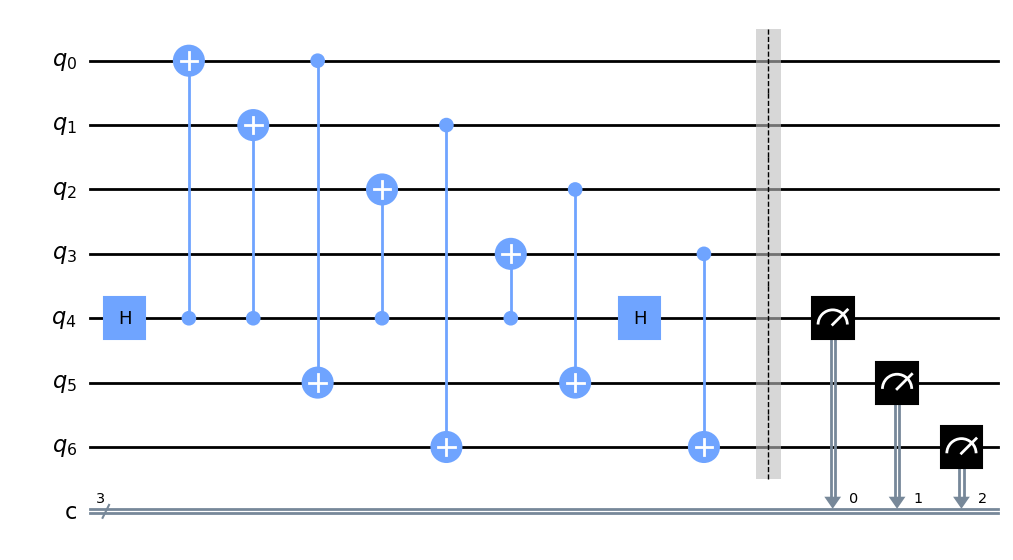

In [5]:
# Create a Quantum Register with 7 qubits (4 data qubits and 3 ancilla qubits for stabilizer + measurement)
qreg = QuantumRegister(7, 'q')

# Create a Classical Register
creg = ClassicalRegister(3, 'c')

# Create a Quantum Circuit for each cycle
sevenq_sc = QuantumCircuit(qreg, creg)

# Entangle with X ancilla (same as above)
sevenq_sc.h(qreg[4])

for i in range (0,4):
    sevenq_sc.cx(qreg[4], qreg[i]) #Remembering X type is control
    
sevenq_sc.h(qreg[4])

#Entangle with Z_1
sevenq_sc.cx(qreg[0], qreg[5])
sevenq_sc.cx(qreg[2], qreg[5])

#entangle with Z_2
sevenq_sc.cx(qreg[1], qreg[6])
sevenq_sc.cx(qreg[3], qreg[6])

sevenq_sc.barrier()

#Check the pre-measurement state
state_simulator = Aer.get_backend('statevector_simulator')
job = execute(sevenq_sc, state_simulator)
state_vector = job.result().get_statevector()

#Measure ancillas
for i in range(0, 3):
        sevenq_sc.measure(qreg[i+4], creg[i])

# Execute the circuit
job = execute(sevenq_sc, simulator, shots=1000)
result = job.result().get_counts()

print("State: ", np.asarray(state_vector).real, "\n Result: ", result)
sevenq_sc.draw('mpl')

We can see that we will be in our desired quiescent state when the ancillas are measured to all be $|000\rangle$ (which happens half the time). So let's now create a function to see how well the 7 qubit error detection surface code detects errors. Instead of running the circuit with all qubits starting in the $|0\rangle$ state, we'll just assume that the quiescent state is $|0\rangle_L$, as defined above. We currently just implement for Pauli errors.

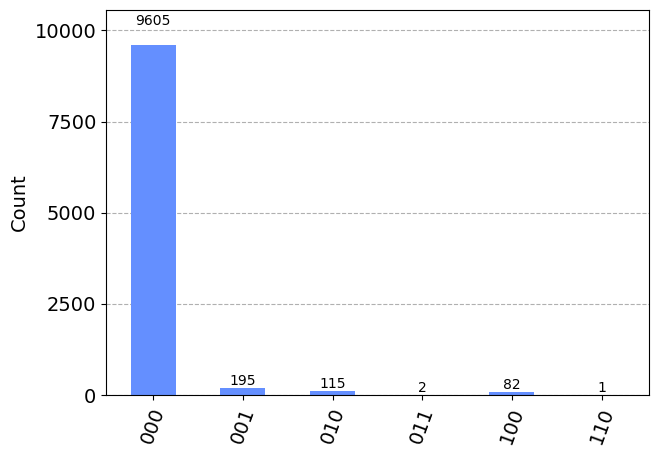

In [6]:
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import pauli_error

def simulate_surface7(num_cycles, p_pauli=0.0):
    # Initialize registers and circuit
    qreg = QuantumRegister(7, 'q')
    creg = ClassicalRegister(num_cycles * 3, 'c')
    circuit = QuantumCircuit(qreg, creg)

    # Define the state vector for the equal superposition of |0000> and |1111>
    state = [1/2**0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/2**0.5]
    circuit.initialize(state, [0, 1, 2, 3])
    
    # Define Pauli error model
    error = pauli_error([('X', 0.5 * p_pauli), ('Z', 0.5 * p_pauli), ('I', 1.0 - p_pauli)])

    for cycle in range(num_cycles):
        
        # Append Pauli errors to each data qubit at the beginning of the cycle
        for i in range(4):
            circuit.append(error, [i])
            
        # Reset ancillas
        for i in range(4, 7):
            circuit.reset(qreg[i])

        # Entangle with X ancilla
        circuit.h(qreg[4])
        for i in range(4):
            circuit.cx(qreg[4], qreg[i])  # X type is control
        circuit.h(qreg[4])

        # Entangle with Z_1
        circuit.cx(qreg[0], qreg[5])
        circuit.cx(qreg[2], qreg[5])

        # Entangle with Z_2
        circuit.cx(qreg[1], qreg[6])
        circuit.cx(qreg[3], qreg[6])

        # Measure ancillas
        for i in range(3):
            circuit.measure(qreg[i + 4], creg[cycle * 3 + i])


        circuit.barrier()

    # Execute the circuit and get the result
    simulator = Aer.get_backend('aer_simulator')
    job = execute(circuit, simulator, shots=10000)
    result = job.result().get_counts()

    return result

# Example Usage
num_cycles = 1
p_pauli = 0.01 # Example probability for Pauli errors
result = simulate_surface7(num_cycles, p_pauli)

# Plot the histogram
plot_histogram(result)

Here we see the codes ability to detect errors. 

### 17 qubit Surface Code
Now following [Low-distance Surface Codes under Realistic Quantum Noise](https://arxiv.org/pdf/1404.3747.pdf), we aim to implement the distance = 3 17 qubit surface code (mainly as it's less resource intensive than the same distance 25 qubit counterpart). The surface-17 consists of 9 data qubits and 8 ancilla qubits.  The stabilizers for the surface-17 are:
- X Stabilizers:
  - $ X_0 X_1 X_3 X_4 $
  - $ X_1 X_2 $
  - $ X_4 X_5 X_7 X_8 $
  - $ X_6 X_7 $
  
- Z Stabilizers:
  - $ Z_0 Z_3 $
  - $ Z_1 Z_2 Z_4 Z_5 $
  - $ Z_3 Z_4 Z_6 Z_7 $
  - $ Z_5 Z_8 $

As an aside, it may seem like an issue that a $Z$ error on qubits 0 and 3 (as $X$ stabilizers check $Z$ errors!) will lead to the same syndome (and $X$ errors for qubits 1 and 2 etc...). However this is not an issue, as we can correct either $Z_1$ or $Z_3$ as it's a stabilizer.

In [7]:
def simulate_surface_17(d3_sc, creg):
    d3_sc.add_register(creg)
    # Reset all ancillas to |0>
    for i in range(9,17):
        d3_sc.reset(i)
    
    # Implementing the stabilizer measurements
    # X-ancilla qubit 9
    d3_sc.h(9)
    d3_sc.cx(9,1)
    d3_sc.cx(9,2)
    d3_sc.h(9)
    d3_sc.measure(9,creg[0])
    d3_sc.barrier()

    # Z ancilla qubit 10
    d3_sc.cx(0,10)
    d3_sc.cx(3,10)
    d3_sc.measure(10, creg[1])
    d3_sc.barrier()

    # X ancilla qubit 11
    d3_sc.h(11)
    d3_sc.cx(11,0)
    d3_sc.cx(11,1)
    d3_sc.cx(11,3)
    d3_sc.cx(11,4)
    d3_sc.h(11)
    d3_sc.measure(11, creg[2])
    d3_sc.barrier()

    # Z ancilla qubit 12
    d3_sc.cx(1,12)
    d3_sc.cx(2,12)
    d3_sc.cx(4,12)
    d3_sc.cx(5,12)
    d3_sc.measure(12, creg[3])
    d3_sc.barrier()

    # Z ancilla qubit 13
    d3_sc.cx(3, 13)
    d3_sc.cx(4, 13)
    d3_sc.cx(6, 13)
    d3_sc.cx(7, 13)
    d3_sc.measure(13, creg[4])
    d3_sc.barrier()


    # X ancilla qubit 14
    d3_sc.h(14)
    d3_sc.cx(14, 4)
    d3_sc.cx(14, 5)
    d3_sc.cx(14, 7)
    d3_sc.cx(14, 8)
    d3_sc.h(14)
    d3_sc.measure(14, creg[5])
    d3_sc.barrier()

    # Z ancilla qubit 15
    d3_sc.cx(5, 15)
    d3_sc.cx(8, 15)
    d3_sc.measure(15, creg[6])
    d3_sc.barrier()

    # X ancilla qubit 16
    d3_sc.h(16)
    d3_sc.cx(16, 6)
    d3_sc.cx(16, 7)
    d3_sc.h(16)
    d3_sc.measure(16, creg[7])
    d3_sc.barrier()



#Example usage 
    
# # Execute the circuit and get the result
# job = execute(d3_sc, simulator, shots=shots)
# result = job.result().get_counts()


# print(result)

# # Organizing the result for each cycle
# organized_result = {}
# for key in result:
#     organized_result[key] = {"counts": result[key], "cycles": []}
#     for cycle in range(num_cycles):
#         cycle_result = key[8 * cycle: 8 * (cycle + 1)]
#         organized_result[key]["cycles"].insert(0, cycle_result)

# for state, data in organized_result.items():
#     for cycle, cycle_result in enumerate(data["cycles"]):
#         print(f"Cycle {cycle}: {cycle_result}")
#     print(f"     Total counts: {data['counts']}")
#     print()  # New line for readability

So we see the state will collapse to any one of the eigenstates of the stabilizers. Then, in the abscence of errors, this state will remain throughout all cycles, and the ancilla measurements will be the same. With the presence of errors, the error will causes a unique change in the ancilla readout/syndrome measurement.

## Decoding with PyMatching
We need some way to decode all the possible error syndromes. For this, we will experiment with [PyMatching](https://github.com/oscarhiggott/PyMatching) (although it remains to be seen how compatible this is with qiskit).
##### Simple Example

We must create $H$, a parity check matrix. Each row of the matrix $H$ represents a different stabilizer (a parity check).
Each column represents a different qubit.
The matrix element $H_{i,j}$ is set to 1 if the $i$-th stabilizer acts on the 
$j$-th qubit (i.e., if the qubit is part of that stabilizer), and 0 otherwise. Read about it in more detail in this PyMatching [Toric Code Example](https://pymatching.readthedocs.io/en/latest/toric-code-example.html) and section III B [here](https://arxiv.org/pdf/1404.3747.pdf). Here is a simple example for the 3 qubit code (recalling the stabilizers are $Z_1Z_2$ and $Z_2Z_3$). 

In [8]:
import numpy as np
from scipy.sparse import csc_matrix
import pymatching

H = csc_matrix([[1, 1, 0],
                 [0, 1, 1]])

weights = np.array([1, 1, 1])   # Set arbitrary weights for illustration
matching = pymatching.Matching(H, weights=weights)
prediction = matching.decode(np.array([1, 1]))
print(prediction)  

[0 1 0]


Let's now create the H matrix for the surface code. We'll have to create two matricies $H_x$ and $H_z$, for the measurement of the $X$ stabilizers and $Z$ stabilizers. For the surface code we have our queiscient state (which is selected from many possible quiescent states), so we don't necessarily know the values of the stabilizer measurements. Therefore, we need to track the **changes** in stabilizer/ancilla measurements between each cycles. The change in the measurement value still allows us to determine where the error has occured.

In [9]:
H_x = np.array([
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 0, 1, 1, 0]
])



H_z = np.array([  
    [1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 1]
])

weights = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])   # Set arbitrary weights for illustration

#Example for X stabilizers
xmatching = pymatching.Matching(H_x, weights = weights)

xprediction = xmatching.decode(np.array([0, 1, 0, 0]))
print("Z Errors: ", xprediction)  

zmatching = pymatching.Matching(H_z, weights = weights)

zprediction = zmatching.decode(np.array([1, 1, 0, 1]))
print("X Errors: ", zprediction)  

Z Errors:  [1 0 0 0 0 0 0 0 0]
X Errors:  [1 0 0 0 0 1 0 0 0]


Let's define a function to do this for the 8 (4 $X$-type, 4 $Z$-type) ancillas of the 17 qubit surface code.

In [10]:
def decode_errors(results):
    H_x = np.array([
        [0, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 0]
    ])

    H_z = np.array([
        [1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1]
    ])

    weights = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1])

    # Extract the binary string
    binary_str = next(iter(results)).replace(" ", "")[::-1] #Due to qiskits little endian
    n_cycles = len(binary_str) // 8

    if len(binary_str) % 8 != 0:
        raise ValueError("Binary string length is not a multiple of 8 after removing spaces. The 17 qubit surface code measures 8 stabilizers.")

    # Initialize pymatching matchers
    xmatching = pymatching.Matching(H_x, weights=weights)
    zmatching = pymatching.Matching(H_z, weights=weights)

    error_reports = []

    for cycle in range(n_cycles - 1):
        start1 = cycle * 8
        start2 = (cycle + 1) * 8
        cycle1 = binary_str[start1:start1 + 8]
        cycle2 = binary_str[start2:start2 + 8]

        # Extract syndromes and calculate differences
        X_syndromes_cycle1 = [int(cycle1[i]) for i in [0, 2, 5, 7]]
        Z_syndromes_cycle1 = [int(cycle1[i]) for i in [1, 3, 4, 6]]
        X_syndromes_cycle2 = [int(cycle2[i]) for i in [0, 2, 5, 7]]
        Z_syndromes_cycle2 = [int(cycle2[i]) for i in [1, 3, 4, 6]]

        Xdifference = [0 if X_syndromes_cycle1[i] == X_syndromes_cycle2[i] else 1 for i in range(4)]
        Zdifference = [0 if Z_syndromes_cycle1[i] == Z_syndromes_cycle2[i] else 1 for i in range(4)]

        # Decode the differences
        xprediction = xmatching.decode(Xdifference)
        zprediction = zmatching.decode(Zdifference)

        cycle_errors = {'cycle': cycle + 1, 'X_error': [], 'Z_error': []}

        # Identify X and Z errors
        for i, x in enumerate(xprediction):
            if x == 1:
                cycle_errors['Z_error'].append(i) #As X stabilizers pick up Z errors

        for i, z in enumerate(zprediction):
            if z == 1:
                cycle_errors['X_error'].append(i) #As X stabilizers pick up Z errors

        error_reports.append(cycle_errors)

    return error_reports



We can see how this works for some test cases. Below, we are able to diagnoze 2 $Z$ errors and 2 $X$ errors during a single cycle.

In [11]:
num_cycles = 4
qreg = 17
d3_sc = QuantumCircuit(qreg)

# Create and add a classical register for each cycle
classical_regs = [ClassicalRegister(8, f'c{cycle}') for cycle in range(num_cycles)]

# Run the simulation for each cycle with its corresponding classical register
for cycle in range(num_cycles):
    simulate_surface_17(d3_sc, classical_regs[cycle])

    if cycle == 0:
        d3_sc.x(0)
        d3_sc.x(5)
        d3_sc.z(2)
        d3_sc.z(7)
    

# Execute the circuit and get the result
job = execute(d3_sc, simulator, shots=1)
result = job.result().get_counts()

# Extract the binary string (assuming there is only one key in the dictionary)
print(result)

err_report = decode_errors(result)

print(err_report)

{'01001111 01001111 01001111 10100100': 1}
[{'cycle': 1, 'X_error': [0, 5], 'Z_error': [2, 7]}, {'cycle': 2, 'X_error': [], 'Z_error': []}, {'cycle': 3, 'X_error': [], 'Z_error': []}]


### Applying Corrections
Qiskit doesn't seem to offer much in the way of conditional gates based on mid-circuit measurements, aside from `c_if`, which we can't use as we're using the classical registers to decode the error syndrome, so there doesn't really seem like a neat way of implementing this result back into a `c_if` statement. Instead, we will use `error_report` at the end of $n$ cycles to apply corrections to the state (i.e. based on our decoded information). It's also worth noting, if the same error occurs an even number of times, we don't need to correct it as it has effectively corrected itself.

In [12]:
from collections import Counter

def apply_error_corrections(qc, error_reports):
    """
    Apply error corrections to the quantum circuit based on error reports.
    Corrects a qubit if it has an odd number of errors.

    Parameters:
    qc (QuantumCircuit): The quantum circuit to apply corrections to.
    error_reports (list): A list of dictionaries containing error reports for each cycle.
    
    Returns:
    QuantumCircuit: The quantum circuit with applied error corrections.
    """
    x_errors = []
    z_errors = []

    # Collect all errors
    for report in error_reports:
        x_errors.extend(report['X_error'])
        z_errors.extend(report['Z_error'])

    # Count occurrences and filter out even occurrences
    x_error_counts = Counter(x_errors)
    z_error_counts = Counter(z_errors)

    # Apply X corrections for odd occurrences
    for qubit, count in x_error_counts.items():
        if count % 2 != 0:  # Odd count
            qc.x(qubit)

    # Apply Z corrections for odd occurrences
    for qubit, count in z_error_counts.items():
        if count % 2 != 0:  # Odd count
            qc.z(qubit)

    return qc

In [13]:
num_cycles = 3
qreg = 17
d3_sc = QuantumCircuit(qreg)

# Create and add a classical register for each cycle
classical_regs = [ClassicalRegister(8, f'c{cycle}') for cycle in range(num_cycles)]

# Run the simulation for each cycle with its corresponding classical register
for cycle in range(num_cycles):
    simulate_surface_17(d3_sc, classical_regs[cycle])

    if cycle == 0:
        d3_sc.x(0)
        d3_sc.x(5)
        d3_sc.z(2)

    if cycle ==1:
        d3_sc.x(0) #These correct themselves
        d3_sc.z(2)

    if cycle == 2:
        d3_sc.z(2) 
    

# Execute the circuit and get the result
job = execute(d3_sc, simulator, shots=1)
result = job.result().get_counts()

#Decode the errors
err_report = decode_errors(result)

print(err_report)

#Apply corrections
apply_error_corrections(d3_sc, err_report)

# d3_sc.draw('mpl')

[{'cycle': 1, 'X_error': [0, 5], 'Z_error': [2]}, {'cycle': 2, 'X_error': [0], 'Z_error': [2]}]


## Bringing it all together
So now we have all the tools we need, all we need to do is bring it together. What will this involve?
- Add a noise model
- Check how well the code performs, e.g. logical error rate vs physical error rate.

For now, let's just create a simple Pauli error noise model. This will just apply an $X$, $Z$ or a combination ($Y$) randomly to the 9 data qubits, given a single qubit error probability.

In [14]:
import random
def apply_random_pauli_errors(circuit, prob):
    """
    Apply random X, Y, or Z gate errors to each qubit in the given circuit with a given probability.

    Args:
    - circuit (QuantumCircuit): The quantum circuit to which the errors will be applied.
    - prob (float): The probability with which an error occurs on each qubit.

    Returns:
    - QuantumCircuit: The modified quantum circuit.
    """
    num_qubits = circuit.num_qubits

    # Ensure that the circuit has at least 9 qubits
    if num_qubits < 9:
        raise ValueError("Circuit must have at least 9 qubits")

    for qubit_index in range(9):  # Iterate over qubits 0 to 8
        # Generate a random number to decide if the error should be applied to this qubit
        if random.random() < prob:
            # Randomly choose between an X, Y, or Z gate
            gate_choice = random.choice(['x', 'y', 'z'])

            # Apply the chosen gate to the qubit
            getattr(circuit, gate_choice)(qubit_index)

    return circuit

#### Qiskit's Density Matricies & State Vectors
To allow us to compare initial and final states (to allow us to calculate logical error rate), we would ideally use qiskits `save_density_matrix` function along with `state_fidelity`. However a $2^{17} \times 2^{17}$ density matrix is a bit too big for this hardware, so we have to just work with the statevector at the moment instead.

In [15]:
# Create your quantum circuit
from qiskit.quantum_info import state_fidelity, Statevector
import numpy as np

qc = QuantumCircuit(2,2)

qc.h(0)
s = Statevector(qc)
print(s)

Statevector([0.70710678+0.j, 0.70710678+0.j, 0.        +0.j,
             0.        +0.j],
            dims=(2, 2))


Let's do this and build the full thing!

In [16]:
def run_simulation(num_shots, num_cycles, p_err):
    fidelities = []
    simulator = Aer.get_backend('aer_simulator')
    state_simulator = Aer.get_backend('statevector_simulator')

    # error = pauli_error([('X', 0.5 * p_err), ('Z', 0.5 * p_err), ('I', 1.0 - p_err)])
    
    for shot in range(num_shots):
        qreg = 17
        d3_sc = QuantumCircuit(qreg)
        classical_regs = [ClassicalRegister(8, f'c{cycle}') for cycle in range(num_cycles+1)]

        for cycle in range(num_cycles):
            simulate_surface_17(d3_sc, classical_regs[cycle])

            if cycle == 0:  # Cycle 0 is state preparation
                d3_sc.save_statevector(label='initial_state')

            #==========================================
            # if cycle != num_cycles - 1:
            #     for i in range(0, 9):
            #         d3_sc.append(error, [i])
            if cycle != num_cycles - 1:
                apply_random_pauli_errors(d3_sc, p_err)

            #==========================================



        job = execute(d3_sc, simulator, shots=1)
        result = job.result().get_counts()
        #----------------------------------------------
        # print(result)
        #----------------------------------------------

        err_report = decode_errors(result)
        #----------------------------------------------
        # print(err_report)
        #----------------------------------------------

        apply_error_corrections(d3_sc, err_report)
        #----------------------------------------------
        #Cycle through once more after applying corrections (?) <----- This is to put ancillas back into desired 'quiescent state' 
        simulate_surface_17(d3_sc,classical_regs[num_cycles])
        #----------------------------------------------

        #Save the final state statevector
        d3_sc.save_statevector(label='final_state')

        #Run the statevector jobs
        transpiled_qc = transpile(d3_sc, state_simulator)
        sv_job = state_simulator.run(transpiled_qc)
        sv_result = sv_job.result()
        initial_state = sv_result.data()['initial_state']
        final_state = sv_result.data()['final_state']

        #Calculate fidelity
        fidelity = state_fidelity(initial_state, final_state)
        fidelities.append(fidelity)
        
    average_fidelity = sum(fidelities) / num_shots
    return average_fidelity

Example usage: 

In [18]:
import time
# Example usage of the function
num_shots = 100
num_cycles = 2
p_err = 0.01
start_time = time.time()
average_fidelity = run_simulation(num_shots, num_cycles, p_err)
end_time = time.time()


print(f"Time taken = {end_time - start_time} seconds")
print("Average fidelity across all shots: ", round(average_fidelity, 3))

Time taken = 28.448439359664917 seconds
Average fidelity across all shots:  1.0


Let's check how well the code performs under these simple Pauli errors. We will plot the average fidelity against the single qubit Pauli error (`p_err`) probability.

Time taken = 341.1859724521637 seconds


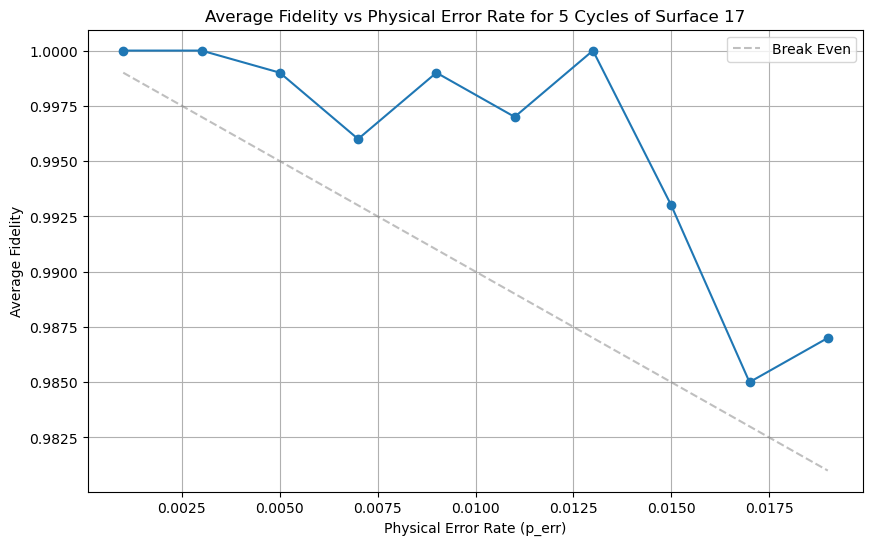

In [25]:
num_shots = 1000
num_cycles = 5
p_err_values = np.arange(0.001, 0.02, 0.002)  # p_err from 0.001 to 0.01 in steps of 0.001
average_fidelities = []

for p_err in p_err_values:
    start_time = time.time()
    average_fidelity = run_simulation(num_shots, num_cycles, p_err)
    end_time = time.time()

    # print(f"p_err = {round(p_err,2)}, Average Fidelity = {round(average_fidelity, 3)}")
    
    average_fidelities.append(average_fidelity)


print(f"Time taken = {end_time - start_time} seconds")

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(p_err_values, average_fidelities, marker='o')
plt.plot(p_err_values, 1 - p_err_values, linestyle='--', alpha=0.5, color='gray', label='Break Even')
plt.title(f"Average Fidelity vs Physical Error Rate for {num_cycles} Cycles of Surface 17")
plt.xlabel("Physical Error Rate (p_err)")
plt.ylabel("Average Fidelity")
plt.grid(True)
plt.legend()
plt.show()

#### Not currently compatible with qiskits quantum channel
Currently, when trying to implement qiskits own quantum channels (e.g. `error = pauli_error([('X', 0.5 * p_err), ('Z', 0.5 * p_err), ('I', 1.0 - p_err)])`), this messes up the fidelity, and causes a different final state, even when no errors occur. This may be due to the method of executing the statevectors...

Another frustrating issue is that qiskit doesn't (seem to) allow the execution of mid-circuit measurements during the computation, as measurements after this will 're-write' the previous measurement results (so if there is any probabilistic state collapse, the state could collapse to one state during the first measurement, then a different one during the second measurement). This makes it hard to extract error syndromes during the computation, and as we've done, we have to extract all error syndromes at the end of $n$ cycles.